In [28]:
#1 Importing Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from scipy import stats
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [29]:
#2 Save root directory path.
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Single_Layer_NN_V1


In [30]:
#3 load Scram codes
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
os.chdir(base_path)

In [31]:
#4 Import the Raw Data for Low temps
EIDlow = pd.DataFrame()
DTFlow_df = pd.DataFrame()


num_files = 65
for n in range(num_files):
    print(n)
    EIDRAW_temp = joblib.load(f'{base_path}\\rawlow\\EID_{n}.pkl')
    DTDdf_temp = joblib.load(f'{base_path}\\rawlow\\DTF_{n}.pkl')
    EIDlow = pd.concat([EIDlow,EIDRAW_temp],ignore_index=True)
    DTFlow_df = pd.concat([DTFlow_df,DTDdf_temp],ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


KeyboardInterrupt: 

In [ ]:
#5 Import the Raw Data for high temps
EIDhigh = pd.DataFrame()
DTFhigh_df = pd.DataFrame()


num_files = 65
for n in range(num_files):
    print(n)
    EIDRAW_temp = joblib.load(f'{base_path}\\rawhigh\\EID_{n}.pkl')
    DTDdf_temp = joblib.load(f'{base_path}\\rawhigh\\DTF_{n}.pkl')
    EIDhigh = pd.concat([EIDhigh,EIDRAW_temp],ignore_index=True)
    DTFhigh_df = pd.concat([DTFhigh_df,DTDdf_temp],ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [ ]:
#6 combine the low and high temp data into one large dataframe
EIDdataraw = pd.concat([EIDlow,EIDhigh],ignore_index=True)
DTDdataraw = pd.concat([DTFlow_df,DTFhigh_df],ignore_index=True)

In [ ]:
#7 Create new dataframes with only the classifications
classifications = pd.DataFrame(DTDdataraw.iloc[:,1]>1)

In [ ]:
#8 Define SNV funciton and normalize the data
total_specrta = EIDdataraw.shape[0]
#Define SNV normalization and perform it on each spectra
def snv(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std_dev = np.std(data, axis=1, keepdims=True)
    return (data - mean) / std_dev
SNV = pd.DataFrame(np.random.uniform(0,100,size=(total_specrta, 2995)))
for i in range(len(EIDdataraw)):
    SNV.iloc[i,:] = snv([EIDdataraw.iloc[i,:].to_numpy().reshape(-1,1).flatten()])[0]

In [ ]:
#9 fit PCA to our normalized data 
pca = PCA(n_components= 5)
EIDdatapca = pca.fit_transform(SNV)

In [ ]:
#10 save our PCA config
joblib.dump(pca,f'{base_path}\\classifier\\pca.pkl')

['C:\\Users\\Matth\\OneDrive\\Desktop\\Single_Layer_NN_V1\\classifier\\pca.pkl']

In [ ]:
#11 Create a dataframe with our the PCA'd data, name the columns to make plotting easier
EIDdatapca_df = pd.DataFrame(data=EIDdatapca, columns = ['PC1','PC2','PC3','PC4','PC5'])

In [ ]:
#12 append the classifications to the PCA dataframe
classifications.columns = ['Type']
EIDdatapca_df= pd.concat([EIDdatapca_df,classifications],axis=1)

In [ ]:
#13 Create new dataframes with only the classifications of true or false (high or low)
filtered_df = EIDdatapca_df[EIDdatapca_df['Type'] == False]
filtered_df1 = EIDdatapca_df[EIDdatapca_df['Type'] == True]

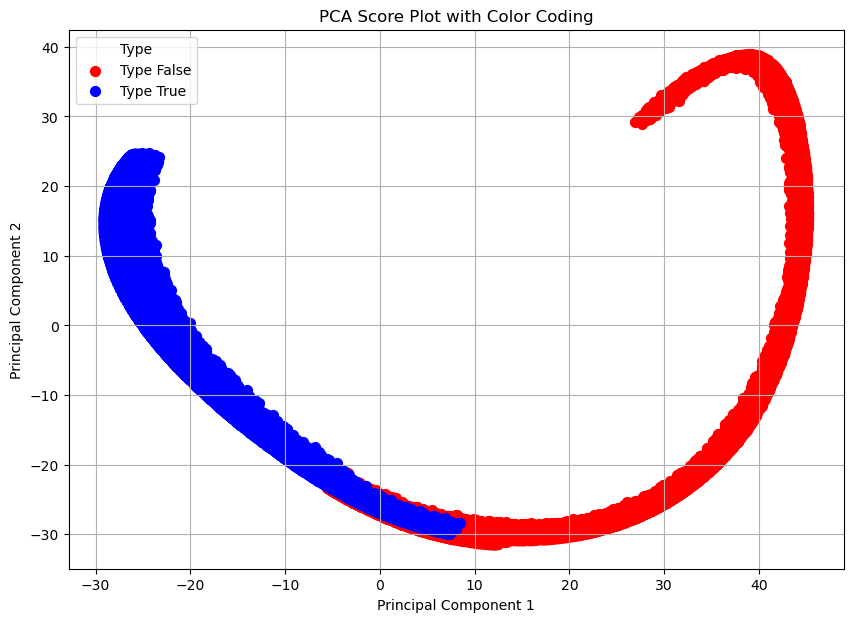

In [ ]:
#14 plot PCA1 vs PCA2 as a sanity check to make sure they are distinct.
plt.figure(figsize=(10, 7))
colors = {0: 'red', 1: 'blue'}
for label in EIDdatapca_df['Type'].unique():
    subset = EIDdatapca_df[EIDdatapca_df['Type'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Type {label}', c=colors[label], s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Score Plot with Color Coding')
plt.legend(title='Type')
plt.grid()
plt.show()

In [ ]:
#15 Verify that the data follows the pattern we expect
EIDdatapca_df

,PC1,PC2,PC3,PC4,PC5,Type
0,43.514475,32.431976,-8.039629,25.787706,-9.749436,False
1,30.825712,33.064677,33.265684,-21.760703,14.844539,False
2,43.442983,4.554560,-32.570944,0.047723,13.707799,False
3,-3.474067,-23.993332,11.187547,7.187366,-0.050287,False
4,31.769017,-23.901046,-16.651566,-13.484119,0.901075,False
...,...,...,...,...,...,...
129995,-28.256765,15.912550,-6.808750,-4.531989,-2.951285,True
129996,-27.894304,10.954852,-4.057473,0.556593,0.563622,True
129997,-28.751973,11.045692,-4.097045,-0.025025,0.331807,True
129998,-19.580836,-6.005449,7.166507,11.550870,7.935819,True


In [ ]:
#16 Split the data into training and validation sets turn them into tensors, and create dataloaders
PCA_train, PCA_val = train_test_split(EIDdatapca_df.iloc[:,:5], test_size=0.2, random_state=42)
type_train, type_val = train_test_split(EIDdatapca_df.iloc[:,5], test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(PCA_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(type_train.to_numpy(), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(PCA_val.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(type_val.to_numpy(), dtype=torch.float32).unsqueeze(1)



dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

valset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
#17 Define the very simple NN used for classification
class classifyingNN(nn.Module):
    def __init__(self):
        super(classifyingNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = classifyingNN()
losses = []
accuracies = []

In [ ]:

# 18 Initialize weights
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)

criterion = nn.BCELoss()

In [ ]:
#19 Define the LR so we can change it on the fly (similar to the model trainer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:


# 20 Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        

        
    
        
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted_labels = (predictions > 0.5).float()
    
    accuracy = (predicted_labels == y_test_tensor).float().mean()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    losses.append(loss.item())
    accuracies.append(accuracy.item())
    model.eval()

# Calculate accuracy
       
        

Epoch [1/1000], Loss: 0.0208, Accuracy: 0.9906
Epoch [2/1000], Loss: 0.0212, Accuracy: 0.9906
Epoch [3/1000], Loss: 0.0211, Accuracy: 0.9906
Epoch [4/1000], Loss: 0.0211, Accuracy: 0.9906
Epoch [5/1000], Loss: 0.0211, Accuracy: 0.9907
Epoch [6/1000], Loss: 0.0209, Accuracy: 0.9906
Epoch [7/1000], Loss: 0.0209, Accuracy: 0.9907
Epoch [8/1000], Loss: 0.0212, Accuracy: 0.9907
Epoch [9/1000], Loss: 0.0208, Accuracy: 0.9906
Epoch [10/1000], Loss: 0.0212, Accuracy: 0.9907
Epoch [11/1000], Loss: 0.0209, Accuracy: 0.9907
Epoch [12/1000], Loss: 0.0212, Accuracy: 0.9907
Epoch [13/1000], Loss: 0.0209, Accuracy: 0.9907
Epoch [14/1000], Loss: 0.0214, Accuracy: 0.9907
Epoch [15/1000], Loss: 0.0209, Accuracy: 0.9907
Epoch [16/1000], Loss: 0.0214, Accuracy: 0.9907
Epoch [17/1000], Loss: 0.0211, Accuracy: 0.9907
Epoch [18/1000], Loss: 0.0212, Accuracy: 0.9907
Epoch [19/1000], Loss: 0.0211, Accuracy: 0.9908
Epoch [20/1000], Loss: 0.0212, Accuracy: 0.9908
Epoch [21/1000], Loss: 0.0212, Accuracy: 0.9908
E

KeyboardInterrupt: 

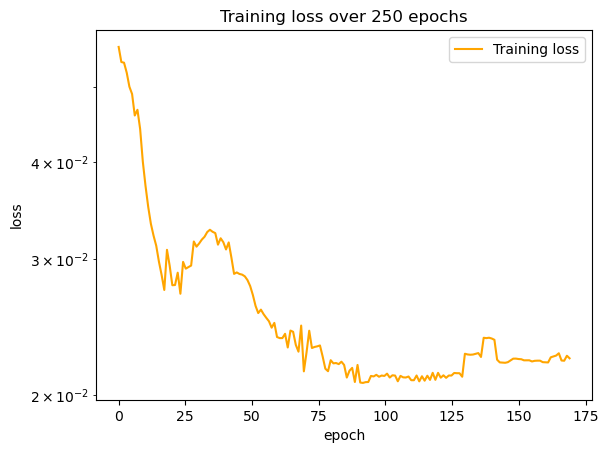

In [32]:
#21 plot loss curve
data = losses
x = np.linspace(0,len(losses), len(losses))
#plt.scatter(x, data, color='orange', label='val_loss_data')

plt.plot(x, data, '-',color='orange', label='Training loss')
#plt.scatter(x, data2, color='blue', label='training_loss_data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
plt.title('Training loss over 250 epochs')
plt.legend()
plt.show()
plt.close()

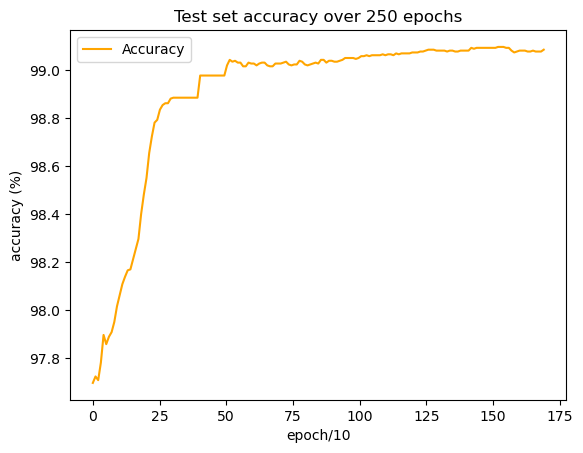

In [33]:
#22 plot accuracy curve
data = np.array(accuracies)*100
x = np.linspace(0,len(accuracies), len(accuracies))
#plt.scatter(x, data, color='orange', label='val_loss_data')

plt.plot(x, data, '-',color='orange', label='Accuracy')
#plt.scatter(x, data2, color='blue', label='training_loss_data')
plt.xlabel('epoch/10')
plt.ylabel('accuracy (%)')
plt.title('Test set accuracy over 250 epochs')

plt.legend()
plt.show()
plt.close()

In [34]:
#23 Create test dataset



# Constants
num_trials = 10000
dx = 0.5e-4  # Single layer of thickness 500 nm

# Initialize SCRAM and get interpolators
scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
en_VH = np.linspace(8, 9.97, 2995)
en_HR = np.linspace(8, 9.97, 2995)  # Spectral range of front side von Hamos spectrometer
j, k, j_f, k_f, fh, fj = scram.get_scram_intrp(dx)

# Pre-generate random values for density, temperature, and fluorescence
densities = np.random.uniform(2.23, 18, num_trials)
temperatures = np.random.uniform(0.1, 6.4, num_trials)
fluorescences = np.random.uniform(1e-4, 1e-2, num_trials)
errors = np.random.uniform(0.0, 0.2, num_trials)

# Prepare arrays to store results
intensities = np.zeros((num_trials, len(en_VH)))
variables = np.zeros((num_trials, 3))

# Loop through each trial

for i in range(num_trials):
    dens = densities[i]
    temp = temperatures[i]
    flor = fluorescences[i]
    error = errors[i]
    target = SCRAMTarget([dens], [temp], j, k, j_f, k_f, fh, fj, en_VH, en_HR, dx)
    
        # Create SCRAM target
        # Generate test spectra
    test_VH, _ = target.model([dens], [temp], flor, 100)
        # Add noise to the spectra
    noise_VH = np.random.normal(0, error * np.std(test_VH), en_VH.shape)
        # Combine the spectra and store in arrays
    intensities[i, :len(en_VH)] = test_VH + noise_VH
    variables[i] = [dens, temp, flor]
    # Convert to DataFrame
    print(i)
energy_intensity_df = pd.DataFrame(intensities)
dens_temp_noise_df = pd.DataFrame(variables)

    # Save DataFrames





5e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [35]:
#24 Run classification model against the test data
real, guess,confidence = [], [], []


for i in range(0,num_trials):

    xydfslice = energy_intensity_df.iloc[i,:]
    xydfslice = xydfslice.to_numpy()

    xydfslice = xydfslice.reshape(1, -1)
    xydfslice = snv(xydfslice)
    xydfslice = pca.transform(xydfslice)
    test_tensor = torch.tensor(xydfslice, dtype=torch.float32)
    model.eval()
    with torch.no_grad():  # Turn off gradients since we're in inference mode
        outputs = model(test_tensor)
        predicted_labels = outputs.detach().numpy()  # Convert to numpy 
        predicted = predicted_labels > 0.5
    
    
    if predicted_labels.flatten()[0] > 0.5:
        conf = predicted_labels.flatten()[0]
    else:
        conf = 1 - predicted_labels.flatten()[0]
    confidence.append(conf)
    
    real.append((dens_temp_noise_df.iloc[i,1]>1).flatten()[0])
    guess.append(predicted.flatten()[0])
    


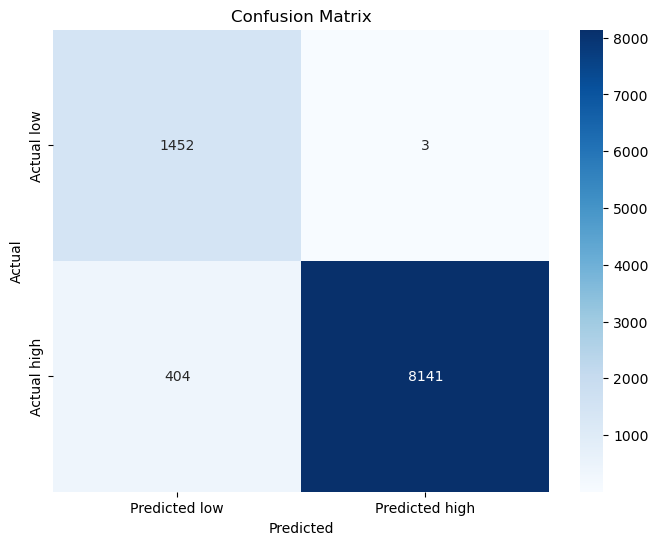

In [36]:
#25 Create and plot the confusion matrix

table = pd.concat([pd.DataFrame(real), pd.DataFrame(guess),pd.DataFrame(confidence),dens_temp_noise_df.iloc[:,1]], axis = 1)
table.columns = ['Real', 'Guess', 'Confidence', 'Temp']
truth_table = table[['Real', 'Guess']]
cm = np.array(confusion_matrix(truth_table.iloc[:,0], truth_table.iloc[:,1]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted low', 'Predicted high'], 
            yticklabels=['Actual low', 'Actual high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
#26 Create a real vs guess with confidence and temperature for the incorrect guesses.
#Use this to see what temperatures tripped up the model. Number of rows = number of incorrect guesses
filtered_table = table[table['Real'] != table['Guess']]
filtered_table

,Real,Guess,Confidence,Temp
13,True,False,0.999708,1.587097
45,True,False,0.647202,1.242228
51,True,False,0.999782,1.574793
59,True,False,0.963858,1.661534
115,True,False,0.999975,1.609413
...,...,...,...,...
9903,True,False,0.916147,1.407218
9911,True,False,0.625971,1.471401
9935,True,False,0.999997,1.446151
9947,True,False,0.579908,1.463344


In [ ]:
filtered_table

In [60]:
#27 save the classification model. 
torch.save(model.state_dict(), f'{base_path}\\models\\classifier.pth')
